In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sympy import *
from scipy.integrate import quad
#plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
init_printing()

In [2]:
N,V,T,Q,L,q,k,h,m,beta = symbols("N V T Q Lambda q k h m beta", positive=True, real=True)
E,S,G,A = symbols("E S G A", real=True)

# Ideal monatomic gas

#### Partition function

In [3]:
L = h/sqrt(2*pi*m/beta) # de Broglie wavelength
q = V/L**3              # translational partition function
Q = q**N / factorial(N) # molecular part. func.; independent particles

#### Energy

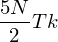

In [4]:
E = -diff(ln(Q), beta) + k*T*V*diff(ln(Q), V)
E.subs(beta, 1/(k*T))

#### Gibb's free energy

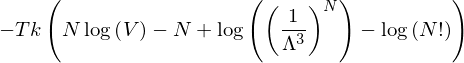

In [5]:
L = symbols('Lambda')
Q = (V/L**3)**N / factorial(N)
G = -k*T*ln(Q) + k*T*V*diff(ln(Q), V)
G = simplify(G)
G

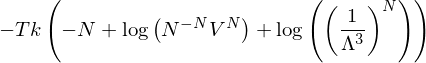

In [6]:
G = G.subs( log(factorial(N)), N*log(N) ) # stirling's approximation
logcombine(G)

# Rotational Partition Function

q_rot       =  19.9028734391
q_rot (HT)  =  19.566099250386532
<E>/kT      =  0.982905507551
<E>/kT (HT) =  1.000001


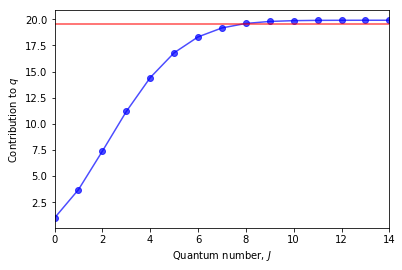

In [7]:
from scipy.constants import h, c, k, N_A
from scipy.misc import derivative 

T = 298.15       # K
B = 10.591 * 100 # 1/m
beta = 1/(k*T)

def q(J,beta):
  return (2*J+1) * np.exp( -beta*h*c*B*J*(J+1) )

def qrot(beta):    # discrete summation
  J = np.arange(0,500,1)
  return np.sum( q(J,beta) )

def qrotHT(beta):  # high temperature limit
  return 1/(beta*h*c*B)

J = np.arange(0,15,1)
plt.plot( J, q(J,beta).cumsum(), 'b-o', alpha=0.7, label='Explicit summation' )
plt.plot( [0,1000], [19.56,19.56], 'r-', alpha=0.7, label='High temperature limit' )
plt.xlim( 0,14 )
plt.xlabel( 'Quantum number, $J$' )
plt.ylabel( 'Contribution to $q$' )

print("q_rot       = ", qrot(beta))
print("q_rot (HT)  = ", qrotHT(beta))
print("<E>/kT      = ", -derivative( qrot, beta, dx=0.001*beta ) / qrot(beta) * beta)
print("<E>/kT (HT) = ", -derivative( qrotHT, beta, dx=0.001*beta ) / qrotHT(beta) * beta)

# Two-level system

Here we consider a system where two energy level are possible; the ground state (0) and the first excited state, $\epsilon$. The partition function is

$$
q = 1+e^{-\epsilon / k_BT}
$$

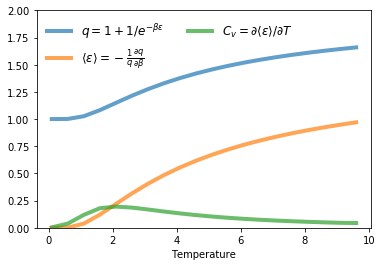

In [12]:
from scipy.constants import h, c, k, N_A # import physical constants

def q(T): return 1+np.exp(-epsilon/(k*T))
def energy(T): return epsilon / (np.exp(epsilon/(k*T)+1) ) # atkins p625 (10th)
def Cv(T): return np.gradient( energy(T)/k, T[1]-T[0] )

fig, ax = plt.subplots()
epsilon=k*4
T=np.arange(0.1, 10, 0.5)
plt.plot(T,q(T), label=r'$q = 1+1 / e^{-\beta \epsilon}$', lw=4, alpha=0.7)
plt.plot(T, energy(T)/k, label=r'$\langle \epsilon \rangle = -\frac{1}{q}\frac{\partial q}{\partial \beta}$',
         lw=4, alpha=0.7)
plt.plot(T, Cv(T), label=r'$C_v=\partial \langle \epsilon \rangle / \partial T$', lw=4, alpha=0.7)
plt.legend(frameon=False, loc=0, fontsize='large', ncol=2)
plt.ylim(0, 2)
plt.xlabel('Temperature')

# Bragg-Williams Model for a Two-component System

This example demonstrates how the Bragg-Williams (BW) model predicts the partial pressure of compoments A and B over a liquid mixture of the two. The interaction parameter $\alpha$ includes the relative A-B neighbor interaction, compared to the A-B and B-B interactions, as well as the number of neighbors, $z$. The partial pressure is given by,
$$
p_A = p_A^0 \chi_A e^{\alpha \chi_B^2}
$$

where $p_A^0$ is the vapor pressure of pure A. If either $\alpha$ or the mole fraction, $\chi_B$, of the other component approach zero, ideal behavior, i.e. Rault's law, is obtained:
$$
p_A = p_A^0 \chi_A
$$

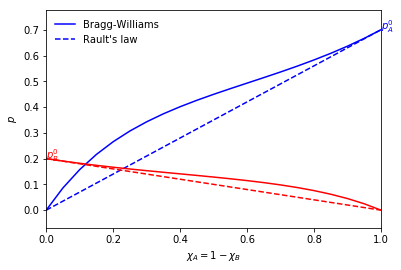

In [9]:
chiA = np.arange(0,1.1,0.05) # mole fraction of A
chiB = 1-chiA                # mole fraction of B

def plotbw(alpha=1, p0A=0.7, p0B=0.2):
    plt.plot( chiA, chiA * p0A * np.exp(alpha*chiB**2),'b-', label='Bragg-Williams'  )
    plt.plot( chiA, chiA * p0A, 'b--', label="Rault's law")    
    plt.plot( chiA, chiB * p0B * np.exp(alpha*chiA**2),'r-')
    plt.plot( chiA, chiB * p0B, 'r--')
    plt.xlim(0,1)

    plt.xlabel(r'$\chi_A=1-\chi_B$')
    plt.ylabel(r'$p$', color='k')
    
    plt.annotate(r'$p_A^0$', (1,p0A), color='blue')
    plt.annotate(r'$p_B^0$', (0,p0B), color='red')
    plt.legend(loc=0, frameon=False)

i = interact(plotbw, alpha=(-3,3, 0.5), p0A=(0,1,0.1), p0B=(0,1,0.1), continuous_update=False )

i.widget.children[0].description=r'$\alpha$'
i.widget.children[1].description=r'$p_A^0$'
i.widget.children[2].description=r'$p_B^0$'

# Equation of State using Generalized van der Waals Theory

This notebook illustrates the generalized van der Waals theory (gvdW) for the equation of state for interacting particles. Based on the lecture notes, _Properties of Molecular Fluids in Equilibrium_ by Sture Nordholm.

### Pair potential

The particles are here assumed to interact via a _Lennard-Jones_ potential,
$$
\beta w(r) =
4\beta \varepsilon_{LJ} \left ( \left ( \frac{\sigma}{r}\right )^{12} - \left ( \frac{\sigma}{r}\right )^{6}\right )
$$

Any potential may in principle be given and must return the energy in units of $k_BT=\beta^{-1}$.

### Interaction parameter

Here we integrate the above pair potential to get the average interaction energy per particle, assuming that the pair correlation function, $g(r)$, can be described by a simple step function, zero when $r<\sigma$, unity otherwise:
$$ 
\hat{a} = -\frac{1}{2} \int_{\sigma}^{\infty} 4\pi w(r) r^2 dr
$$

In this Notebook we simply do the integration numerically so that we can use arbitrary pair potentials.
From this we calculate the pressure, $p$, versus density, $n$, using,
$$
\beta p_{gvdW} = \frac{1}{v-v_0} - \frac{\hat{a}}{v^2}
$$

where $v=1/n$ and $v_0=2\pi\sigma^3/3$ is the particle volume.
For reference we'll also plot EOS for an ideal system (van 't Hoff), $\beta p_{ideal}=n$,
where $\beta = 1/k_BT$.

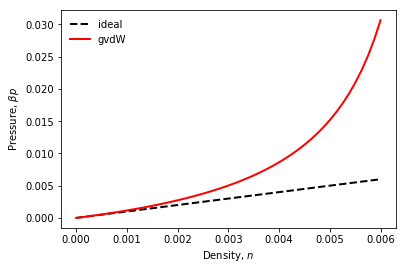

In [10]:
def pairpotential(r, eps, sigma): # Lennard-Jones potential
    return 4 * eps * ( (sigma/r)**12 - (sigma/r)**6 )

def Pgvdw(n, eps, sigma):
    a  = -2*pi*quad(lambda r: pairpotential(r, eps, sigma)*r**2, sigma, np.infty, limit=20)[0]
    v0 = 2*pi*sigma**3 / 3
    v  = 1 / n
    return 1/(v-v0) - a/v**2

def Pideal(n): # ideal gas law
    return n

def plot( eps=0, sigma=4.0 ):
    plt.plot(n, Pideal(n),  'k--', label='ideal', lw=2)
    plt.plot(n, Pgvdw(n, eps, sigma),  'r-', label='gvdW', lw=2)
    plt.legend(loc=0, frameon=False)
    
    plt.xlabel(r'Density, $n$')
    plt.ylabel(r'Pressure, $\beta p$')

n = np.linspace(1e-7, 6e-3, 50)    
i = interact(plot, eps=(0.0, 2.0, 0.1), sigma=(0, 5, 0.1), continuous_update=False )
 
i.widget.children[0].description=r'$\beta\varepsilon_{LJ}$'
i.widget.children[1].description=r'$\sigma_{LJ}$'